In [1]:
# import libraries
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.image as imgpt
from sklearn.pipeline import Pipeline


Text(0.5, 1.0, 'Background Removed Example')

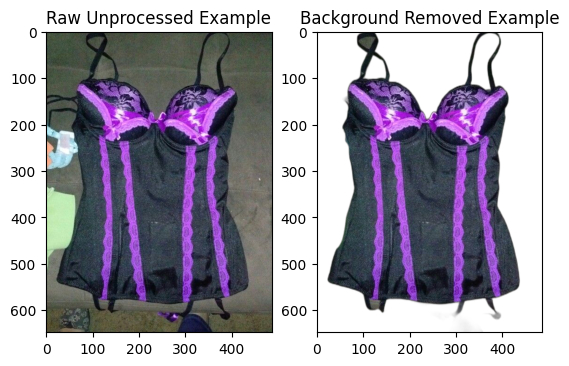

In [2]:
# plot raw RAW unprocessed image
# reading the image
rawImage = imgpt.imread('images/bustier_corset/pinterest_699324648411162597.jpg')
semiImage = imgpt.imread('rmbg_imgs/bustier_hourglass/pinterest_699324648411162597.jpg')

%matplotlib inline 
# displaying the image
plt.subplot(1,2,1)
plt.imshow(rawImage)
plt.title("Raw Unprocessed Example")

plt.subplot(1,2,2)
plt.imshow(semiImage)
plt.title("Background Removed Example")

In [4]:
# load numpy array from npy file
images = load('images.npy')
labels = load('labels.npy')

### Raw Data Code

Text(0.5, 1.0, '(Label: babydoll/trapeze)')
Text(0.5, 1.0, '(Label: bustier/hourglass)')
Text(0.5, 1.0, '(Label: tshirt/straight)')


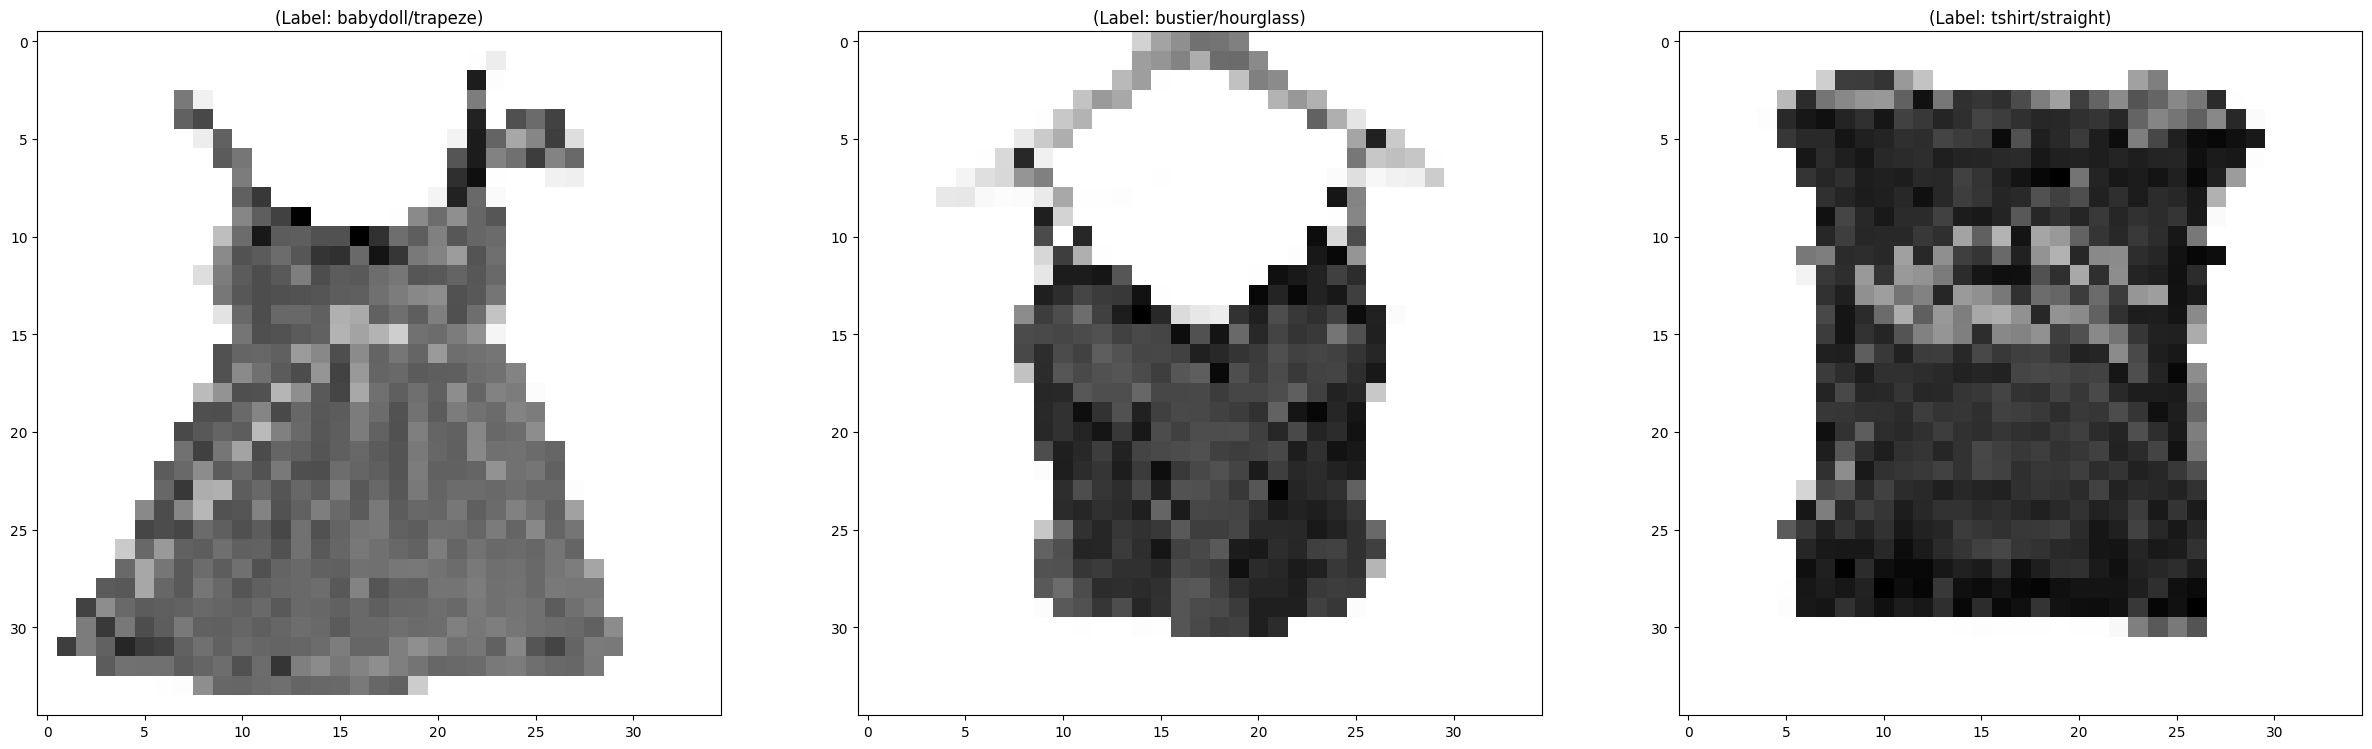

In [5]:
# plot first image of each class

label_list = {
    0: 'babydoll/trapeze',
    1: 'bustier/hourglass',
    2: 'tshirt/straight',
}

 # first image of each class
values = [0, 435, 870]

%matplotlib inline

plt.figure(figsize = [30,15])

for i in range(3):
    plt.subplot(1,3,i+1)
    im = np.reshape(images[values[i]],(35,35))
    plt.imshow(im, cmap='gray_r')
    print(plt.title("(Label: " + str(label_list[labels[values[i]]]) + ")"))

In [6]:
# define functions to call for repetitive tasks to minimize code length

# function to call to get y_pred, accuracy, confusion matrix, classification report for any model
def predict(model, xtrain, ytrain, xtest, ytest):
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    if len(ytest)>0:
        #computer the performance matrices for this model
        score = accuracy_score(ytest, y_pred)
        confusion_mat = confusion_matrix(ytest, y_pred)
        class_report = classification_report(ytest, y_pred)
        return y_pred, score, confusion_mat, class_report
    else:
        return y_pred
    
# function to create df from confusion matrix 
def create_confmat_df(x):
    
    "Create a df from given confusion matrix by calculating FP, FN, TP, TN, SPECIFICITY, SENSITIVTY, ACCURACY"

    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    # sensitivity, hit rate, recall, TPR
    TPR = TP/(TP+FN)
    # specificity/true negative rate
    TNR = TN/(TN+FP)
    #overall accuracy(by class)
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # create table
    df = pd.DataFrame({'CLASS': np.array([0,1,2]), 'FP': FP, 'FN': FN, 'TP': TP, 'TN': TN, 'SENSITIVITY': TPR, 'SPECIFICITY': TNR, 'ACCURACY': ACC})
    df.set_index('CLASS', inplace=True)
    return df

In [7]:
# choosing train test split to test optimal parameters for classification methods
# train size = 0.85 because dataset is small

xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)

In [13]:
# use gridsearchcv with RAW DATA to determine optimal size K
knn = KNeighborsClassifier()
k_range = list(range(1, 50))
distance = [2]
param_grid = dict(n_neighbors=k_range, p=distance)
  
# defining parameter range
# cv =5 cross validation folds for each k value
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


Accuracy for our training dataset with tuning is : 83.68%
{'n_neighbors': 3, 'p': 2}


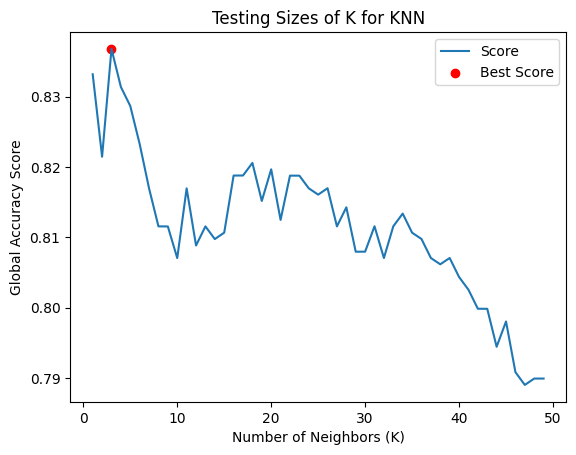

In [14]:
# optimal size k
allgridscores = list(grid_search.cv_results_['mean_test_score'])
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(grid_search.best_score_ *100) )
print(grid_search.best_params_)

plt.plot(k_range, allgridscores, label='Score')
plt.scatter(k_range[2], allgridscores[2], label='Best Score', color='red')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Global Accuracy Score')
plt.title('Testing Sizes of K for KNN')
plt.legend()

In [15]:
# find optimal params for non-linear svm using raw data
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
svm_grid=GridSearchCV(svc,param_grid, scoring='accuracy', verbose=1)

# fitting the model for grid search
svm_gridsearch = svm_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [16]:
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(svm_gridsearch.best_score_ *100) )
print(svm_gridsearch.best_params_)

Accuracy for our training dataset with tuning is : 89.18%
{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


In [17]:
results_svm = svm_gridsearch.cv_results_
svmtable = pd.DataFrame(results_svm)
svmtable.drop(['params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'], axis=1, inplace=True)
svmtable = svmtable.sort_values(by=['rank_test_score']).head(10)
# to add to pdf
print(svmtable.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrlllrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_C & param\_gamma & param\_kernel &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       0.97733 &       0.18966 &          0.03727 &         0.00303 &       1 &           1 &         poly &          0.89178 &         0.00961 &                1 \\
       4.74502 &       1.07780 &          0.17183 &         0.08391 &     100 &     0.10000 &         poly &          0.89178 &         0.00961 &                1 \\
       1.83878 &       0.82175 &          0.06710 &         0.02165 &      10 &           1 &         poly &          0.89178 &         0.00961 &                1 \\
       2.08071 &       0.63645 &          0.06739 &         0.01225 &      10 &     0.10000 &         poly &          0.89178 &         0.00961 &                1 \\
       2.29620 &       0.63265 &          0.09487 &         0.09488 &       1 &     0.10000 &         poly 

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_35091/246238813.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svmtable.to_latex(index=False,


In [7]:
# initiate optimal knn model 
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2)
# initiate optimal svm model 
svc=svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True)

# call function
pred_knn, knn_score, knn_confusion, knn_classreport = predict(knn, xtrain, ytrain, xtest, ytest)
pred_svc, svc_score, svc_confusion, svc_classreport = predict(svc, xtrain, ytrain, xtest, ytest)

print("Overall Accuracy: {0:.2f}".format(knn_score))
print("Overall Accuracy: {0:.2f}".format(svc_score))

Overall Accuracy: 0.84
Overall Accuracy: 0.92


In [17]:
# create df from create_confmat_df func

svc_df = create_confmat_df(svc_confusion)
knn_df = create_confmat_df(knn_confusion)

# save to csv to avoid recomputing

svc_df.to_csv("svc_df.csv")
knn_df.to_csv("knn_df.csv")

In [9]:
svc_df = pd.read_csv("svc_df.csv")
knn_df = pd.read_csv("knn_df.csv")

In [10]:
svc_df

,CLASS,FP,FN,TP,TN,SENSITIVITY,SPECIFICITY,ACCURACY
0,0,5,4,61,126,0.938462,0.961832,0.954082
1,1,2,9,56,129,0.861538,0.984733,0.943878
2,2,8,2,64,122,0.969697,0.938462,0.948980


In [11]:
knn_df

,CLASS,FP,FN,TP,TN,SENSITIVITY,SPECIFICITY,ACCURACY
0,0,15,5,60,116,0.923077,0.885496,0.897959
1,1,5,25,40,126,0.615385,0.961832,0.846939
2,2,12,2,64,118,0.969697,0.907692,0.928571


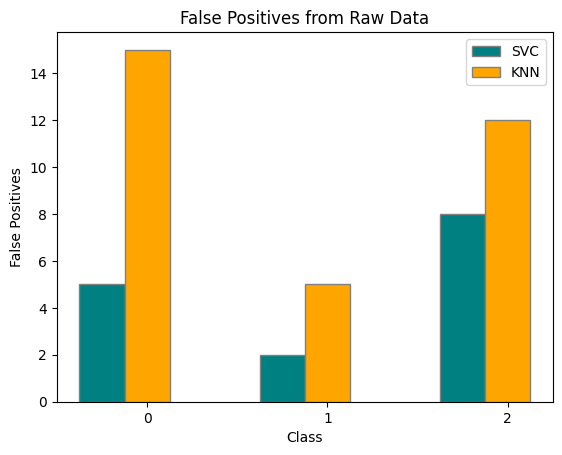

In [21]:
barWidth = 0.25
br1 = np.arange(len(svc_df))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, svc_df.FP, color ='teal', width = barWidth,
        edgecolor ='grey', label ='SVC')
plt.bar(br2, knn_df.FP, color ='orange', width = barWidth,
        edgecolor ='grey', label ='KNN')
 
# Adding Xticks
plt.xlabel('Class')
plt.ylabel('False Positives')
plt.title('False Positives from Raw Data')
plt.xticks([r + barWidth for r in range(len(svc_df))],
        ['0', '1', '2'])
 
plt.legend()
plt.show()

## PCA representation 

In [6]:
# initiate PCA
pca = PCA(n_components=1225)
# project our data into PC space
pca_images = pca.fit_transform(images)

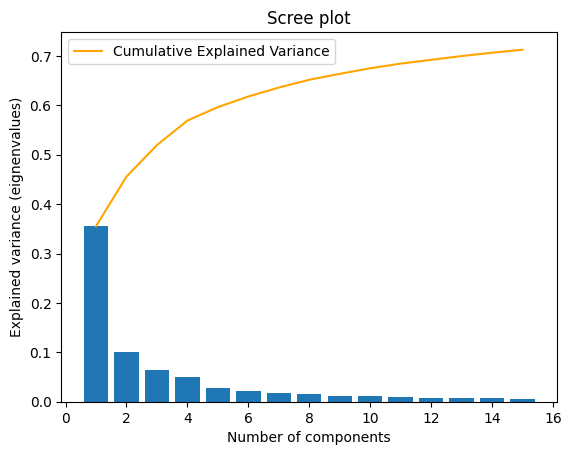

In [7]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_ratio_[0:15])+1),
    pca.explained_variance_ratio_[0:15]
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ratio_[0:15])+1),
    np.cumsum(pca.explained_variance_ratio_[0:15]),
    c='orange',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

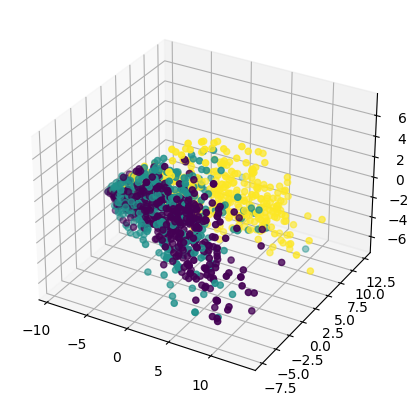

In [29]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(pca_images[:,0], pca_images[:,1],pca_images[:,2], c=labels)
plt.show()

In [22]:
# initiate optimal knn model to test the optimal pca dimensions
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2)
# initiate optimal svm model to test optimal pca
svc=svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True)

# percentage of explained variance to test
ncomponents = np.array([0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96])
test_Scores = []
svmtest_Scores = []

for i in ncomponents:
    tryPCA = PCA(n_components= i)
    transformed = tryPCA.fit_transform(images)
    basis = np.dot(transformed, tryPCA.components_)
    xtrain, xtest, ytrain, ytest = train_test_split(basis, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)
    knn.fit(xtrain, ytrain)
    svc.fit(xtrain, ytrain)
    ypredknn = knn.predict(xtest)
    knnout = accuracy_score(ytest, ypredknn)
    test_Scores.append(knnout)
    ypredsvc = svc.predict(xtest)
    svcout = accuracy_score(ytest, ypredsvc)
    svmtest_Scores.append(svcout)

In [23]:
print(test_Scores[3])
print(svmtest_Scores[2])
print(svmtest_Scores[3])

0.9030612244897959
0.9183673469387755
0.9132653061224489


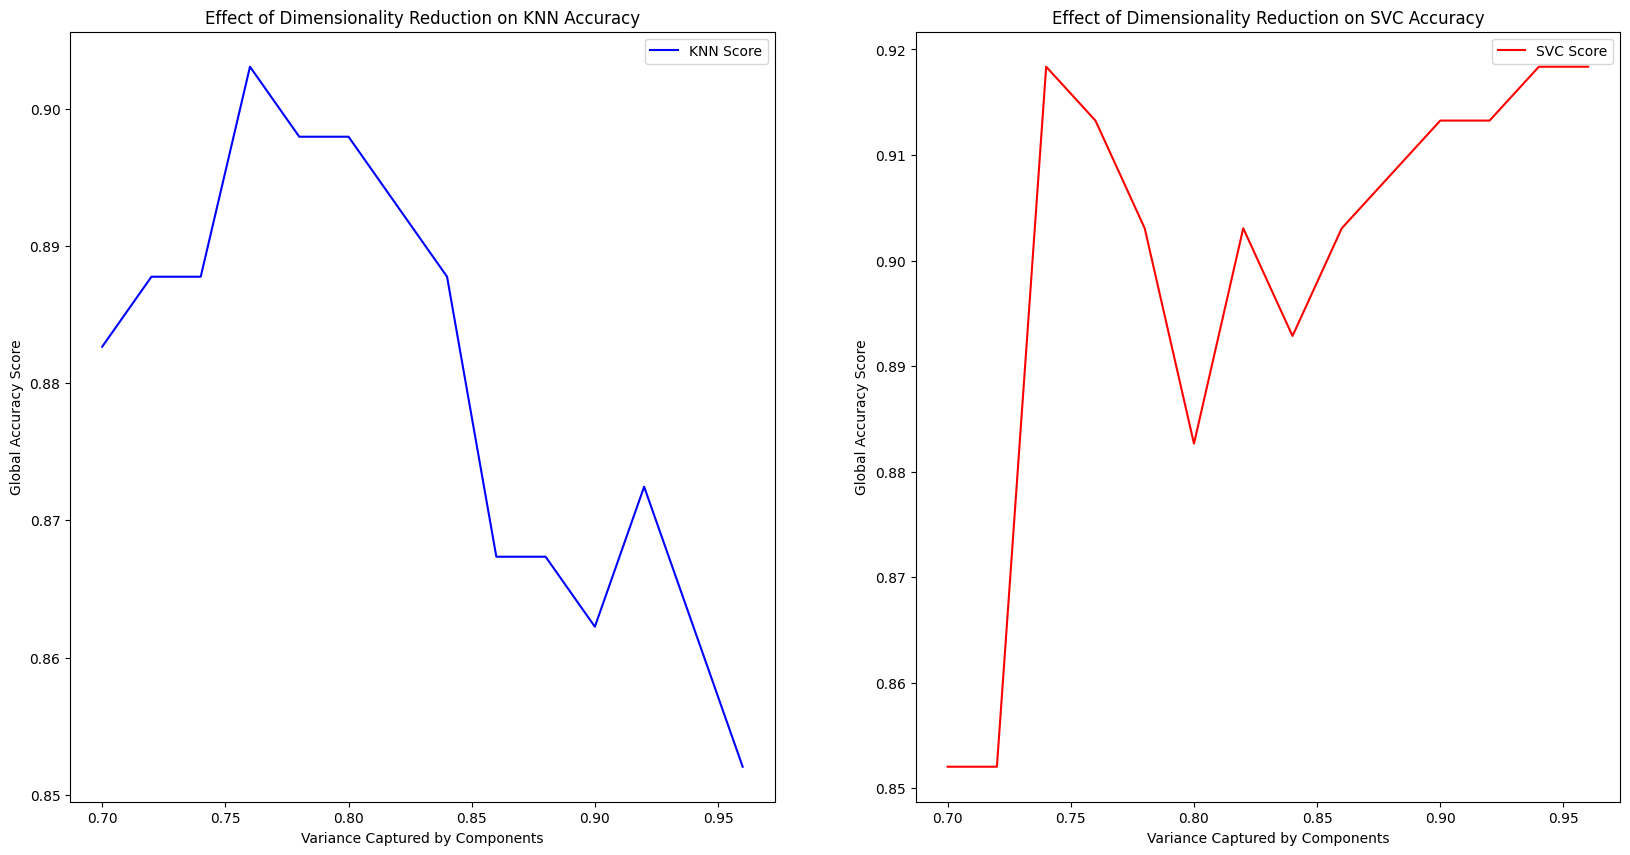

In [24]:
# compare results 

%matplotlib inline

plt.figure(figsize = [20,10])

plt.subplot(1,2,1)
plt.plot(ncomponents, test_Scores, color='b', label='KNN Score')
plt.xlabel('Variance Captured by Components')
plt.ylabel('Global Accuracy Score')
plt.title('Effect of Dimensionality Reduction on KNN Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ncomponents, svmtest_Scores, color='red',label='SVC Score')
plt.xlabel('Variance Captured by Components')
plt.ylabel('Global Accuracy Score')
plt.title('Effect of Dimensionality Reduction on SVC Accuracy')
plt.legend()
plt.show()

In [69]:
# recreate optimal combinations
# initiate optimal knn model to test the optimal pca dimensions
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2)
# initiate optimal svm model to test optimal pca
svc=svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True)

bestPCA = PCA(n_components= 0.76)
transformed = bestPCA.fit_transform(images)
basis = np.dot(transformed, bestPCA.components_)
xtrain, xtest, ytrain, ytest = train_test_split(basis, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)

# call function
pred_pcaknn, knn_pca_score, knn_pca_confusion, knn_pcareport = predict(knn, xtrain, ytrain, xtest, ytest)
pred_pcasvc, svc_pca_score, svc_pca_confusion, svc_pcareport = predict(svc, xtrain, ytrain, xtest, ytest)

# scores
print("Overall Accuracy: {0:.2f}".format(knn_pca_score))
print("Overall Accuracy: {0:.2f}".format(svc_pca_score))

Overall Accuracy: 0.90
Overall Accuracy: 0.91


In [101]:
bestPCA.components_

(27, 1225)

In [102]:
transformed.shape

(1305, 27)

In [103]:
basis.shape

(1305, 1225)

27
Text(0.5, 1.0, '(Label: babydoll/trapeze)')
Text(0.5, 1.0, '(Label: bustier/hourglass)')
Text(0.5, 1.0, '(Label: tshirt/straight)')


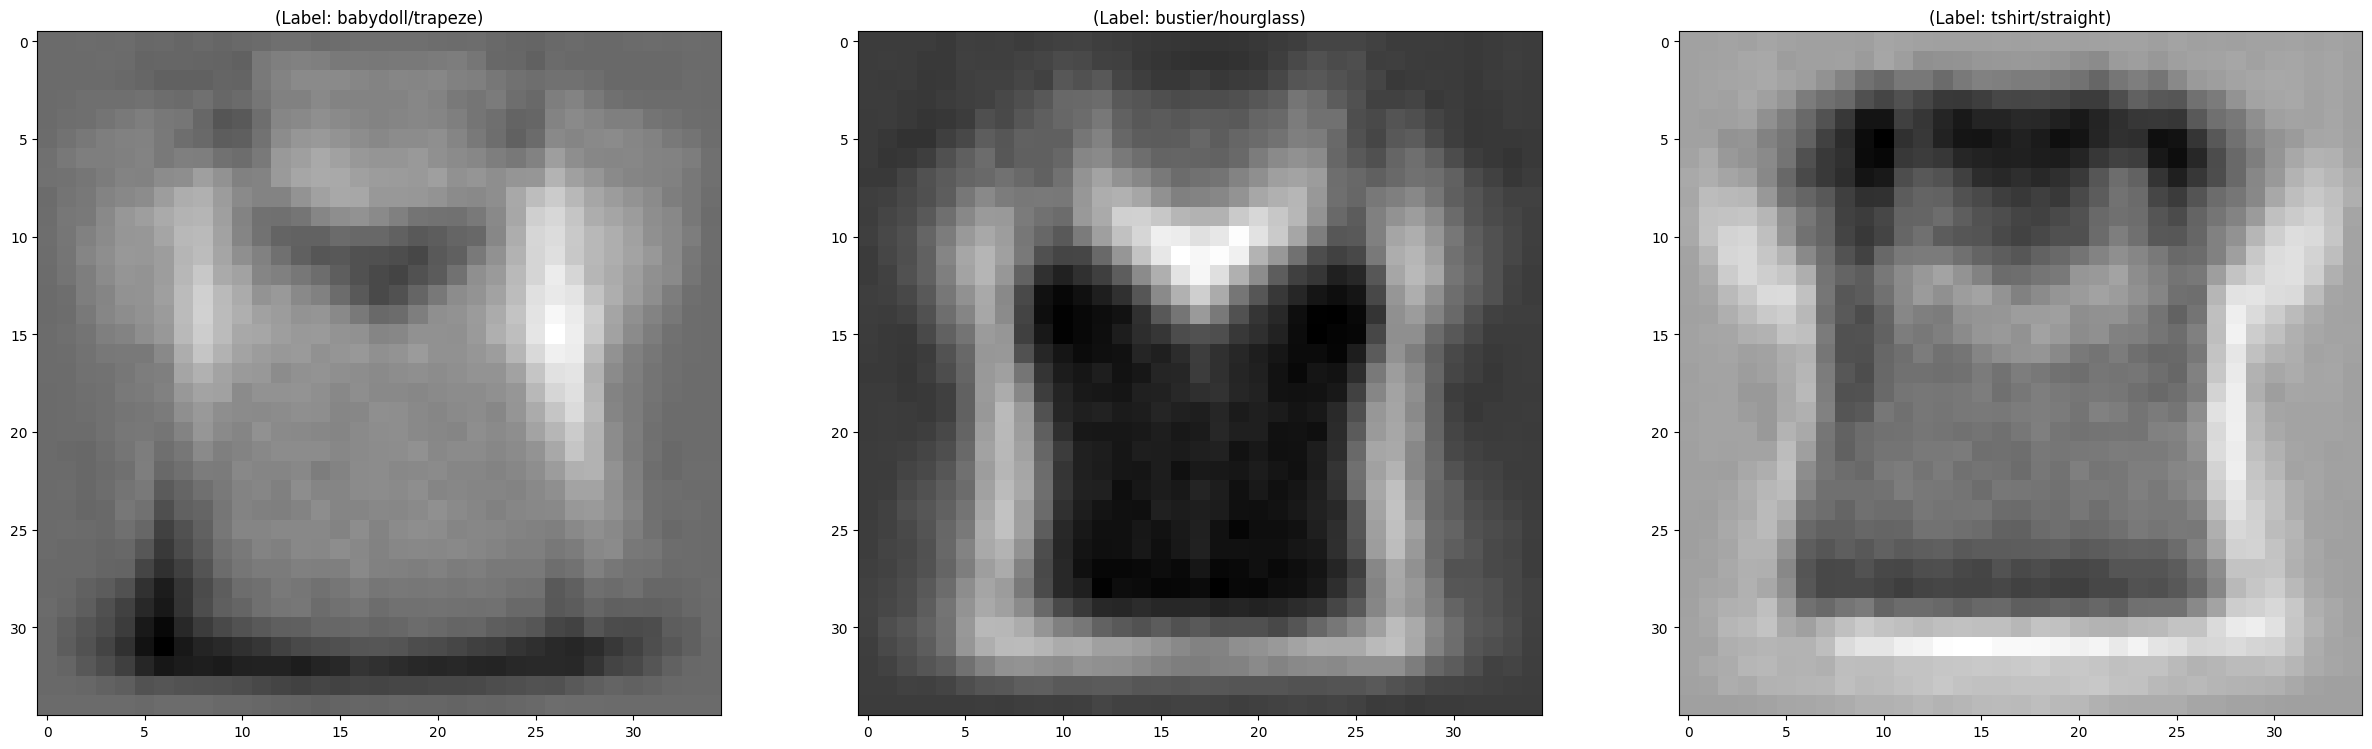

In [32]:
 # first image of each class RECONSTRUCTED AFTER PCA
# number of components kept
print(bestPCA.n_components_)
values = [0, 435, 870]
%matplotlib inline
plt.figure(figsize = [30,15])
for i in range(3):
    plt.subplot(1,3,i+1)
    im = np.reshape(basis[values[i]],(35,35))
    plt.imshow(im, cmap='gray_r')
    print(plt.title("(Label: " + str(label_list[labels[values[i]]]) + ")"))

In [15]:
# use create_confmat_df func to create df
svc_pca_df = create_confmat_df(svc_pca_confusion)
knn_pca_df = create_confmat_df(knn_pca_confusion)

# save to csv to avoid recomputing
svc_pca_df.to_csv("svc_pca_df.csv")
knn_pca_df.to_csv("knn_pca_df.csv")

In [12]:
svc_pca_df= pd.read_csv("svc_pca_df.csv")
knn_pca_df = pd.read_csv("knn_pca_df.csv")

In [13]:
svc_pca_df

,CLASS,FP,FN,TP,TN,SENSITIVITY,SPECIFICITY,ACCURACY
0,0,7,5,60,124,0.923077,0.946565,0.938776
1,1,4,10,55,127,0.846154,0.969466,0.928571
2,2,6,2,64,124,0.969697,0.953846,0.959184


In [14]:
knn_pca_df

,CLASS,FP,FN,TP,TN,SENSITIVITY,SPECIFICITY,ACCURACY
0,0,8,3,62,123,0.953846,0.938931,0.943878
1,1,3,15,50,128,0.769231,0.977099,0.908163
2,2,8,1,65,122,0.984848,0.938462,0.954082


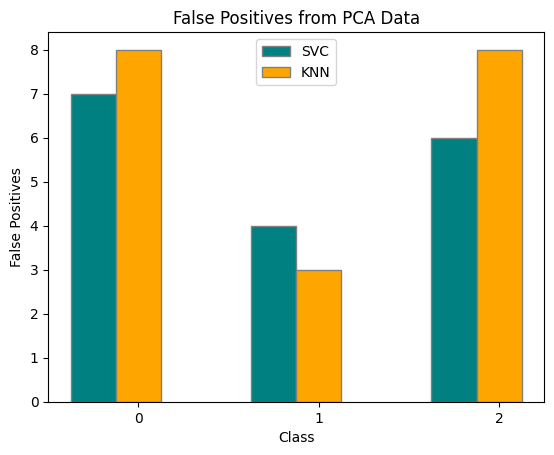

In [23]:
barWidth = 0.25
br1 = np.arange(len(svc_pca_df))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, svc_pca_df.FP, color ='teal', width = barWidth,
        edgecolor ='grey', label ='SVC')
plt.bar(br2, knn_pca_df.FP, color ='orange', width = barWidth,
        edgecolor ='grey', label ='KNN')
 
# Adding Xticks
plt.xlabel('Class')
plt.ylabel('False Positives')
plt.title('False Positives from PCA Data')
plt.xticks([r + barWidth for r in range(len(svc_df))],
        ['0', '1', '2'])
 
plt.legend()
plt.show()

## Kernel PCA Representation

Limitations of using kernel PCA:


The value of gamma for the ‘rbf’, ‘poly’ and ‘sigmoid’ kernels should be specified by the user as a hyperparameter. It requires implementing a hyperparameter tuning technique such as Random Search or Grid Search.
Unlike in PCA, the n_component hyperparameter does not accept a float value. So, we cannot select the best number of components by specifying the amount of variance that needs to be explained by the principal components.

In [34]:
from sklearn.metrics import mean_squared_error

# find the optimal kpca hyper parameters  
from sklearn.pipeline import Pipeline

clf = Pipeline([
 ("kpca", KernelPCA()),
 ("knn", KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2))
 ])
param_grid = [{
 "kpca__n_components": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600],
 "kpca__gamma": np.linspace(0.001, 0.05, 10),
 "kpca__kernel": ["rbf"]
 }]
kpcagrid_search = GridSearchCV(clf, param_grid, cv=3)
kpcagrid_search.fit(images, labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=3))]),
             param_grid=[{'kpca__alpha': array([0.5  , 0.275, 0.05 ]),
                          'kpca__gamma': array([0.001     , 0.00644444, 0.01188889, 0.01733333, 0.02277778,
       0.02822222, 0.03366667, 0.03911111, 0.04455556, 0.05      ]),
                          'kpca__kernel': ['rbf'],
                          'kpca__n_components': [10, 20, 30, 40, 50, 60, 70, 80,
                                                 90, 100, 200, 300, 400, 500,
                                                 600]}])

In [36]:
# find the optimal kpca hyper parameters  
# pipeline for sigmoid and poly kernels

clf = Pipeline([
 ("kpca", KernelPCA()),
 ("knn", KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2))
 ])
param_grid = [{
 "kpca__n_components": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600],
 "kpca__gamma": np.linspace(0.001, 0.05, 10),
 "kpca__coef0": np.linspace(0.001, 0.05, 10),
 "kpca__degree": [2,3,4,5],
 "kpca__kernel": ["poly", "sigmoid"]
 }]
kpcagrid_search2 = GridSearchCV(clf, param_grid, cv=3)
kpcagrid_search2.fit(images, labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=3))]),
             param_grid=[{'kpca__coef0': array([0.001     , 0.00644444, 0.01188889, 0.01733333, 0.02277778,
       0.02822222, 0.03366667, 0.03911111, 0.04455556, 0.05      ]),
                          'kpca__degree': [2, 3, 4, 5],
                          'kpca__gamma': array([0.001     , 0.00644444, 0.01188889, 0.01733333, 0.02277778,
       0.02822222, 0.03366667, 0.03911111, 0.04455556, 0.05      ]),
                          'kpca__kernel': ['poly', 'sigmoid'],
                          'kpca__n_components': [10, 20, 30, 40, 50, 60, 70, 80,
                                                 90, 100, 200, 300, 400, 500,
                                                 600]}])

In [37]:
kpcagrid_search2.best_score_

0.8735632183908045

In [38]:
kpcagrid_search2.best_params_

{'kpca__coef0': 0.028222222222222225,
 'kpca__degree': 2,
 'kpca__gamma': 0.0064444444444444445,
 'kpca__kernel': 'sigmoid',
 'kpca__n_components': 40}

Accuracy for our training dataset with tuning is : 86.74%
{'kpca__alpha': 0.5, 'kpca__gamma': 0.01188888888888889, 'kpca__kernel': 'rbf', 'kpca__n_components': 70}


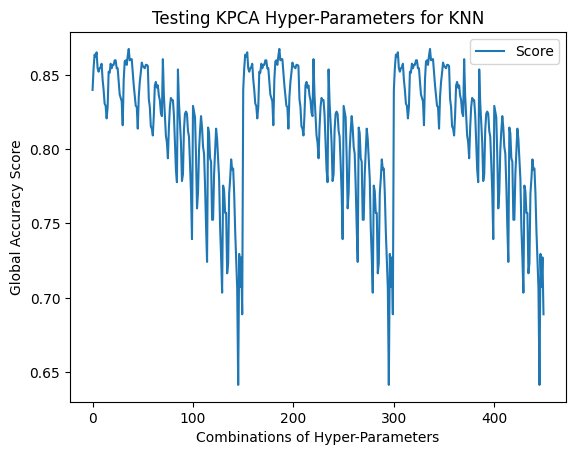

In [35]:
# plot scores from gridsearch for optimal hyperparameters for KPCA and KNN
kpcaallgridscores = list(kpcagrid_search.cv_results_['mean_test_score'])
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(kpcagrid_search.best_score_ *100) )
print(kpcagrid_search.best_params_)

plt.plot(list(range(len(kpcaallgridscores))), kpcaallgridscores, label='Score')
# plt.scatter(k_range[2], allgridscores[2], label='Best Score', color='red')
plt.xlabel('Combinations of Hyper-Parameters')
plt.ylabel('Global Accuracy Score')
plt.title('Testing KPCA Hyper-Parameters for KNN')
plt.legend()

In [41]:
kpcaknntable2 = pd.DataFrame(kpcagrid_search2.cv_results_)
kpcaknntable2 = kpcaknntable2.sort_values(by=['rank_test_score']).head(5)

#save as csv so don't have to run again (took more than 1 hour)
kpcaknntable2.to_csv("kpcaknntable2.csv")

# to add to pdf
print(kpcaknntable2.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrllllllrrrrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_kpca\_\_coef0 & param\_kpca\_\_degree & param\_kpca\_\_gamma & param\_kpca\_\_kernel & param\_kpca\_\_n\_components &                                             params &  split0\_test\_score &  split1\_test\_score &  split2\_test\_score &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       0.11481 &       0.03030 &          0.04523 &         0.00561 &           0.03367 &                  3 &           0.00644 &            sigmoid &                       40 & \{'kpca\_\_coef0': 0.033666666666666664, 'kpca\_\_de... &            0.86667 &            0.90115 &            0.85287 &          0.87356 &         0.02030 &                1 \\
       0.06771 &       0.01031 &          0.03819 &         0.00686 &           0.02822 &                  4 &           0.00644 &            sigmoid &                       40 & \{'kpca\_\_coef0': 0.028

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_53389/2047647430.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(kpcaknntable2.to_latex(index=False,


In [42]:
# create table 
kpcaknntable = pd.DataFrame(kpcagrid_search.cv_results_)
kpcaknntable = kpcaknntable.sort_values(by=['rank_test_score']).head(5)

kpcaknntable.to_csv("kpcaknntable.csv")
# to add to pdf
print(kpcaknntable.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrlllllrrrrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_kpca\_\_alpha & param\_kpca\_\_gamma & param\_kpca\_\_kernel & param\_kpca\_\_n\_components &                                             params &  split0\_test\_score &  split1\_test\_score &  split2\_test\_score &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       0.12473 &       0.00770 &          0.06489 &         0.01301 &           0.50000 &           0.01189 &                rbf &                       70 & \{'kpca\_\_alpha': 0.5, 'kpca\_\_gamma': 0.011888888... &            0.86897 &            0.88736 &            0.84598 &          0.86743 &         0.01693 &                1 \\
       0.15389 &       0.02212 &          0.05749 &         0.00148 &           0.05000 &           0.01189 &                rbf &                       70 & \{'kpca\_\_alpha': 0.05, 'kpca\_\_gamma': 0.01188888... &            0.86897 &            0

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_53389/2493849087.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(kpcaknntable.to_latex(index=False,


In [68]:
# # svc grid search
# clfsvc = Pipeline([
#  ("kpca", KernelPCA()),
#  ("svc", svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True))
#  ])
# param_grid = [{
#  "kpca__n_components": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600],
#  "kpca__gamma": np.linspace(0.001, 0.05, 10),
#  "kpca__coef0": np.linspace(0.001, 0.05, 10),
#  "kpca__degree": [2,3,4,5],
#  "kpca__kernel": ["rbf", "poly", "sigmoid"]
#  }]
# kpcagrid_searchsvc = GridSearchCV(clfsvc, param_grid, cv=3)
# kpcagrid_searchsvc.fit(images, labels)

# grid search for optimal kpca hyper parameters with svc EXTREMELY COMPUTATIONALLY EXPENSIVE 
# TRYING TO TEST SAME PARAMETERS AS TESTED FOR KPCA-->KNN RAN FOR 13+ HOURS WITH NO CONCLUSION
# forced to kill kernel and try another method

In [42]:
# svc grid search part 1
clfsvc = Pipeline([
 ("kpca", KernelPCA()),
 ("svc", svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True))
 ])
param_grid = [{
 "kpca__n_components": [50, 100, 500],
 "kpca__gamma": [0.005, 0.01, 0.1, 0.5, 1, 5],
 "kpca__degree": [2,3,4],
 "kpca__kernel": ["poly","sigmoid"]
 }]
kpcagrid_searchsvc = GridSearchCV(clfsvc, param_grid, cv=3)
kpcagrid_searchsvc.fit(images, labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('svc',
                                        SVC(C=0.1, gamma=1, kernel='poly',
                                            probability=True))]),
             param_grid=[{'kpca__degree': [2, 3, 4],
                          'kpca__gamma': [0.005, 0.01, 0.1, 0.5, 1, 5],
                          'kpca__kernel': ['poly', 'sigmoid'],
                          'kpca__n_components': [50, 100, 500]}])

In [47]:
# create table 
kpcasvctable = pd.DataFrame(kpcagrid_searchsvc.cv_results_)

kpcasvctable.to_csv("kpcasvctable.csv")

kpcasvctable = kpcasvctable.sort_values(by=['rank_test_score']).head(5)
# to add to pdf
print(kpcasvctable.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrlllllrrrrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_kpca\_\_degree & param\_kpca\_\_gamma & param\_kpca\_\_kernel & param\_kpca\_\_n\_components &                                             params &  split0\_test\_score &  split1\_test\_score &  split2\_test\_score &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       0.21810 &       0.03482 &          0.02287 &         0.00103 &                  4 &           0.01000 &               poly &                      100 & \{'kpca\_\_degree': 4, 'kpca\_\_gamma': 0.01, 'kpca\_... &            0.89195 &            0.85747 &            0.89425 &          0.88123 &         0.01682 &                1 \\
       0.19961 &       0.00397 &          0.02476 &         0.00251 &                  3 &           0.01000 &               poly &                      100 & \{'kpca\_\_degree': 3, 'kpca\_\_gamma': 0.01, 'kpca\_... &            0.88736 &        

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_34565/2322199882.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(kpcasvctable.to_latex(index=False,


In [43]:
print(kpcagrid_searchsvc.best_params_)
print(kpcagrid_searchsvc.best_score_)

{'kpca__degree': 4, 'kpca__gamma': 0.01, 'kpca__kernel': 'poly', 'kpca__n_components': 100}
0.8812260536398467


In [46]:
# svc grid search part 2
clfsvc = Pipeline([
 ("kpca", KernelPCA()),
 ("svc", svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True))
 ])
param_grid2 = [{
 "kpca__n_components": [50, 100, 500],
 "kpca__gamma": [0.005, 0.01, 0.1, 0.5, 1, 5],
 "kpca__kernel": ["rbf"]
 }]
kpcagrid_searchsvc2 = GridSearchCV(clfsvc, param_grid2, cv=3)
kpcagrid_searchsvc2.fit(images, labels)

print(kpcagrid_searchsvc2.best_params_)
print(kpcagrid_searchsvc2.best_score_)

{'kpca__gamma': 0.01, 'kpca__kernel': 'rbf', 'kpca__n_components': 50}
0.5325670498084292


In [48]:
# create table 
kpcasvctable2 = pd.DataFrame(kpcagrid_searchsvc2.cv_results_)

kpcasvctable2.to_csv("kpcasvctable2.csv")

kpcasvctable2 = kpcasvctable2.sort_values(by=['rank_test_score']).head(5)
# to add to pdf
print(kpcasvctable2.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrllllrrrrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_kpca\_\_gamma & param\_kpca\_\_kernel & param\_kpca\_\_n\_components &                                             params &  split0\_test\_score &  split1\_test\_score &  split2\_test\_score &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       0.29945 &       0.02681 &          0.04163 &         0.00165 &           0.01000 &                rbf &                       50 & \{'kpca\_\_gamma': 0.01, 'kpca\_\_kernel': 'rbf', 'k... &            0.54483 &            0.58391 &            0.46897 &          0.53257 &         0.04772 &                1 \\
       0.34519 &       0.00860 &          0.05514 &         0.01588 &           0.01000 &                rbf &                      100 & \{'kpca\_\_gamma': 0.01, 'kpca\_\_kernel': 'rbf', 'k... &            0.54713 &            0.56322 &            0.46207 &          0.52414 &         0.04438

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_34565/4266352687.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(kpcasvctable2.to_latex(index=False,


In [7]:
# optimal kpca params for SVC
kpca = KernelPCA(n_components=100, gamma=0.01, coef0=1, degree=4, kernel='poly', fit_inverse_transform=True)
svc = svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True)

xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)


kpcasvc_xtrain = kpca.fit_transform(xtrain)
kpcasvc_xtest = kpca.transform(xtest)

# call predict() function 

predsvckpca, kpca_svcscore, kpca_svc_confusion, kpca_svc_report = predict(svc, kpcasvc_xtrain, ytrain, kpcasvc_xtest, ytest)
kpca_svc_confdf = create_confmat_df(kpca_svc_confusion)
# save confusion matrix to avoid recomputing
kpca_svc_confdf.to_csv("kpca_svc_confdf.csv")

print("Overall Accuracy: {0:.2f}".format(kpca_svcscore))

Overall Accuracy: 0.93


In [38]:
# repeat optimal KPCA for KNN
kpcaknn = KernelPCA(n_components=40, kernel='sigmoid', degree=2, gamma= 0.0064444444444444445, fit_inverse_transform=True, alpha = 5e-3)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2)

kpcaknn_xtrain = kpcaknn.fit_transform(xtrain)
kpcaknn_xtest = kpcaknn.transform(xtest)

# call predict() function 

predknnkpca, kpca_knnscore, kpca_knn_confusion, kpca_knn_report = predict(knn, kpcaknn_xtrain, ytrain, kpcaknn_xtest, ytest)
kpca_knn_confdf = create_confmat_df(kpca_knn_confusion)
# save confusion matrix to avoid recomputing
kpca_knn_confdf.to_csv("kpca_knn_confdf.csv")

print("Overall Accuracy: {0:.2f}".format(kpca_knnscore))

Overall Accuracy: 0.90


In [24]:
kpca_knn_confdf = pd.read_csv("kpca_knn_confdf.csv")
kpca_svc_confdf = pd.read_csv("kpca_svc_confdf.csv")

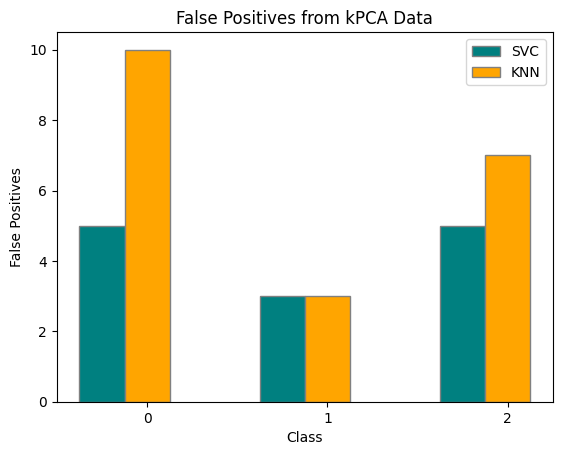

In [25]:
barWidth = 0.25
br1 = np.arange(len(kpca_svc_confdf))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, kpca_svc_confdf.FP, color ='teal', width = barWidth,
        edgecolor ='grey', label ='SVC')
plt.bar(br2, kpca_knn_confdf.FP, color ='orange', width = barWidth,
        edgecolor ='grey', label ='KNN')
 
# Adding Xticks
plt.xlabel('Class')
plt.ylabel('False Positives')
plt.title('False Positives from kPCA Data')
plt.xticks([r + barWidth for r in range(len(svc_df))],
        ['0', '1', '2'])
 
plt.legend()
plt.show()

In [39]:
# inverse transform --> reconstruct images for both instances of kpca

# kpcaknn
invkpca_xtrainknn = kpcaknn.inverse_transform(kpcaknn_xtrain)
invkpca_xtestknn = kpcaknn.inverse_transform(kpcaknn_xtest)

# kpcasvc
invkpca_xtrainsvc = kpca.inverse_transform(kpcasvc_xtrain)
invkpca_xtestsvc = kpca.inverse_transform(kpcasvc_xtest)

Text(0.5, 1.0, '(Train Label: babydoll/trapeze)')
Text(0.5, 1.0, '(Train Label: bustier/hourglass)')
Text(0.5, 1.0, '(Train Label: tshirt/straight)')
Text(0.5, 1.0, '(Test Label: babydoll/trapeze)')
Text(0.5, 1.0, '(Test Label: bustier/hourglass)')
Text(0.5, 1.0, '(Test Label: tshirt/straight)')


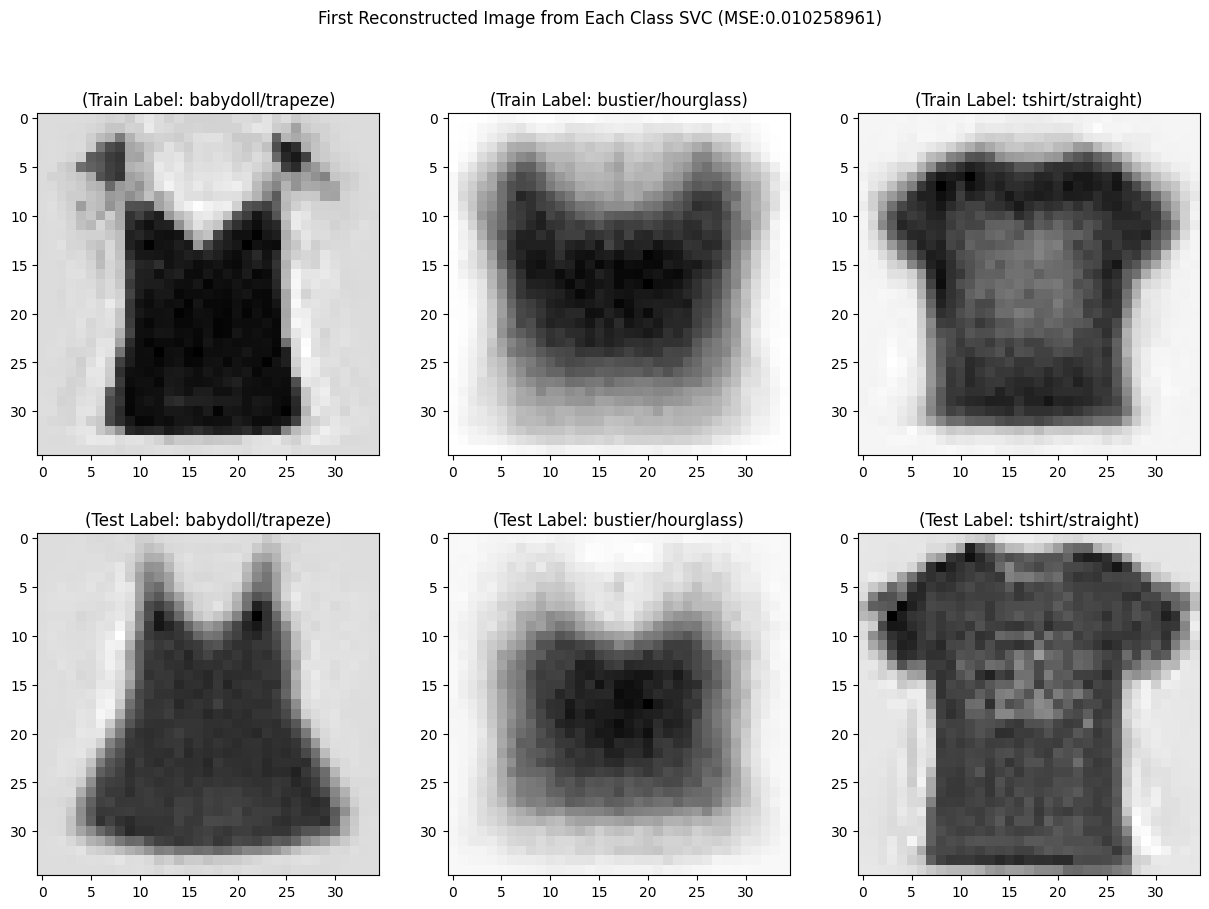

In [42]:
# plot reconstructed images of first reconstructed img of each class from SVC instance
find = [8, 1, 0, 2, 3, 0]
%matplotlib inline
plt.figure(figsize = [15,10])
for i in range(6):
    if i < 3:
        plt.subplot(2,3,i+1)
        im = np.reshape(invkpca_xtrainsvc[find[i]],(35,35))
        plt.imshow(im, cmap='gray_r')
        plt.suptitle("First Reconstructed Image from Each Class SVC" + " (MSE:" + str(np.mean((xtrain - invkpca_xtrainsvc) ** 2)) + ")")
        print(plt.title("(Train Label: " + str(label_list[ytrain[find[i]]]) + ")"))
    else:
        plt.subplot(2,3,i+1)
        im = np.reshape(invkpca_xtestsvc[find[i]],(35,35))
        plt.imshow(im, cmap='gray_r')
        print(plt.title("(Test Label: " + str(label_list[ytest[find[i]]]) + ")"))

Text(0.5, 1.0, '(Train Label: babydoll/trapeze)')
Text(0.5, 1.0, '(Train Label: bustier/hourglass)')
Text(0.5, 1.0, '(Train Label: tshirt/straight)')
Text(0.5, 1.0, '(Test Label: babydoll/trapeze)')
Text(0.5, 1.0, '(Test Label: bustier/hourglass)')
Text(0.5, 1.0, '(Test Label: tshirt/straight)')


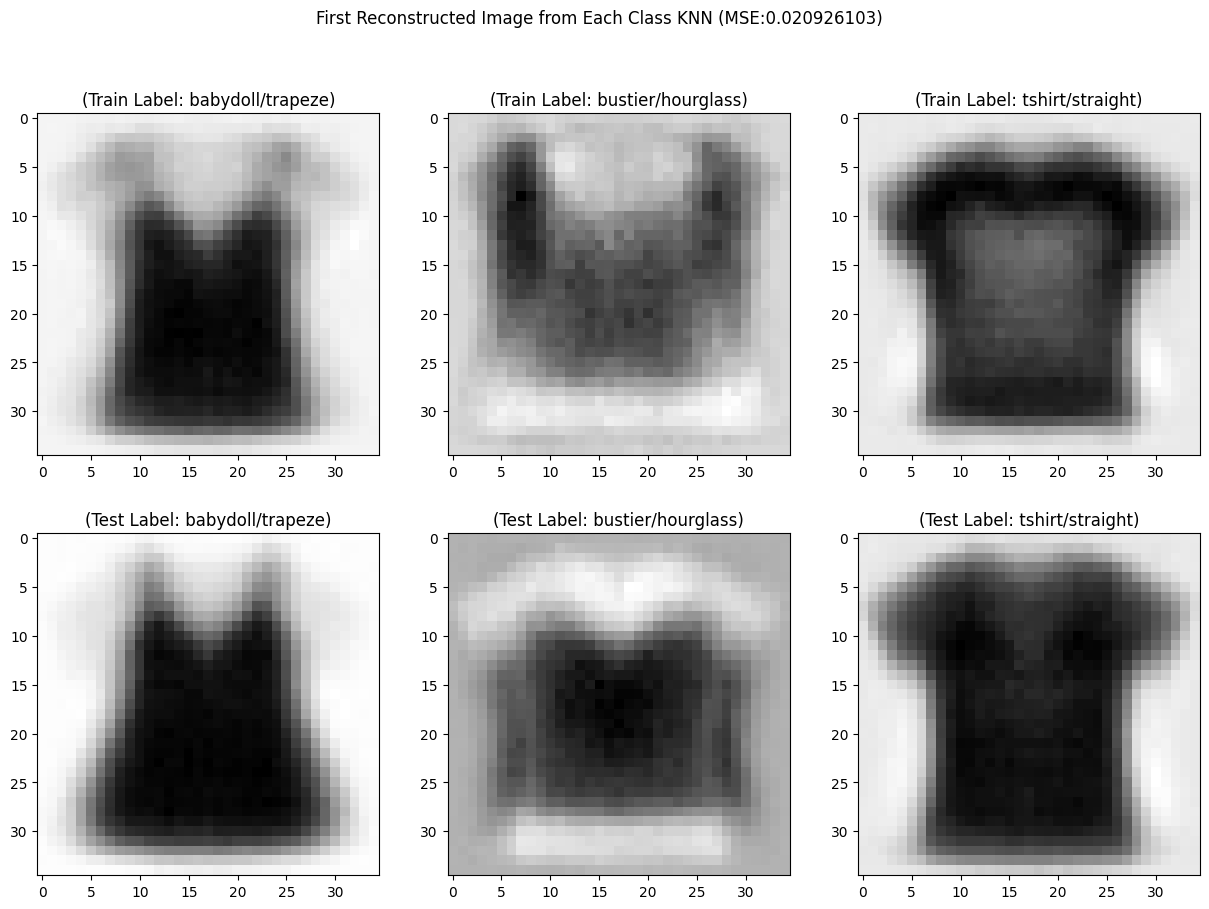

In [41]:
# plot reconstructed images of first reconstructed img of each class from KNN instance
%matplotlib inline
plt.figure(figsize = [15,10])
for i in range(6):
    if i < 3:
        plt.subplot(2,3,i+1)
        im = np.reshape(invkpca_xtrainknn[find[i]],(35,35))
        plt.imshow(im, cmap='gray_r')
        plt.suptitle("First Reconstructed Image from Each Class KNN" + " (MSE:" + str(np.mean((xtrain - invkpca_xtrainknn) ** 2)) + ")")
        print(plt.title("(Train Label: " + str(label_list[ytrain[find[i]]]) + ")"))
    else:
        plt.subplot(2,3,i+1)
        im = np.reshape(invkpca_xtestknn[find[i]],(35,35))
        plt.imshow(im, cmap='gray_r')
        print(plt.title("(Test Label: " + str(label_list[ytest[find[i]]]) + ")"))

## Isomap Code :)

Isomap can be used in the medical field to make ultrasound & echocardiography images better interpretable with noise removal. The manifold learning algorithm is applied to two-dimensional echocardiography images to discover the relationship between the frames of consecutive cycles of the heart motion

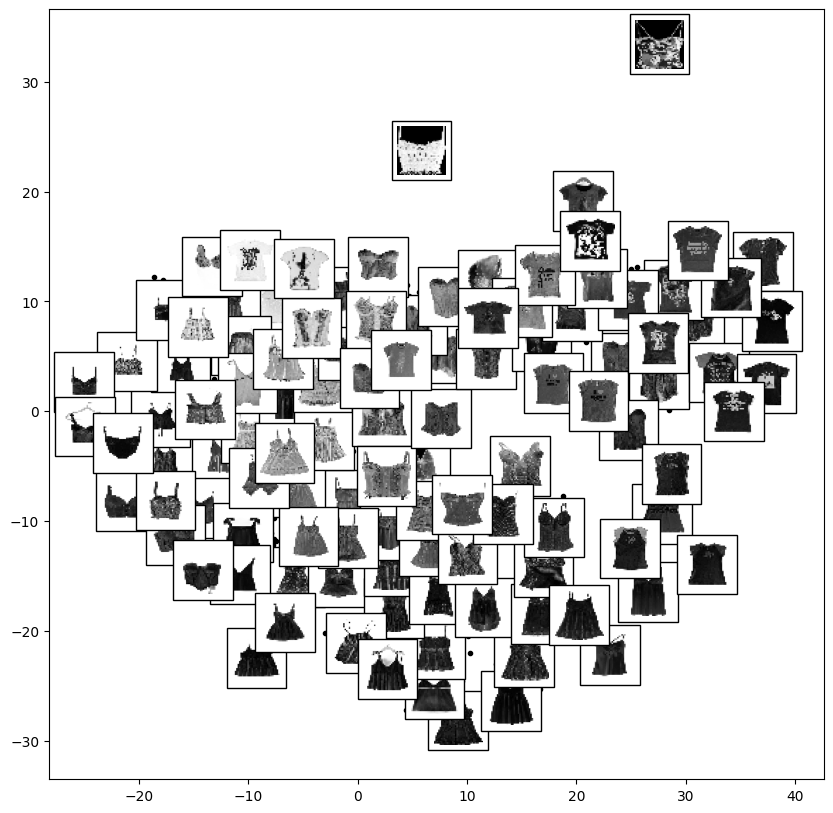

In [17]:
from sklearn.manifold import Isomap
from matplotlib.offsetbox import AnnotationBbox
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

from sklearn.manifold import Isomap
model = Isomap(n_components=2)


fig, ax = plt.subplots(figsize=(10, 10))
plot_components(images, model, images=images.reshape((-1, 35, 35)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

In [13]:
# initiate optimal knn model to test the optimal pca dimensions
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2)
# initiate optimal svm model to test optimal pca
svc=svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True)

# percentage of explained variance to test
radius = np.array([3, 7, 11, 15, 20, 30, 40, 50, 75, 100])
knntest_Scores = []
svctest_Scores = []

for i in radius:
    isomap = Isomap(n_components = 30, n_neighbors= i, n_jobs=-1, metric='euclidean', p=2)
    postmap = isomap.fit_transform(images)
    xtrain, xtest, ytrain, ytest = train_test_split(postmap, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)
    knn.fit(xtrain, ytrain)
    svc.fit(xtrain, ytrain)
    ypredknn = knn.predict(xtest)
    knnout = accuracy_score(ytest, ypredknn)
    knntest_Scores.append(knnout)
    ypredsvc = svc.predict(xtest)
    svcout = accuracy_score(ytest, ypredsvc)
    svctest_Scores.append(svcout)

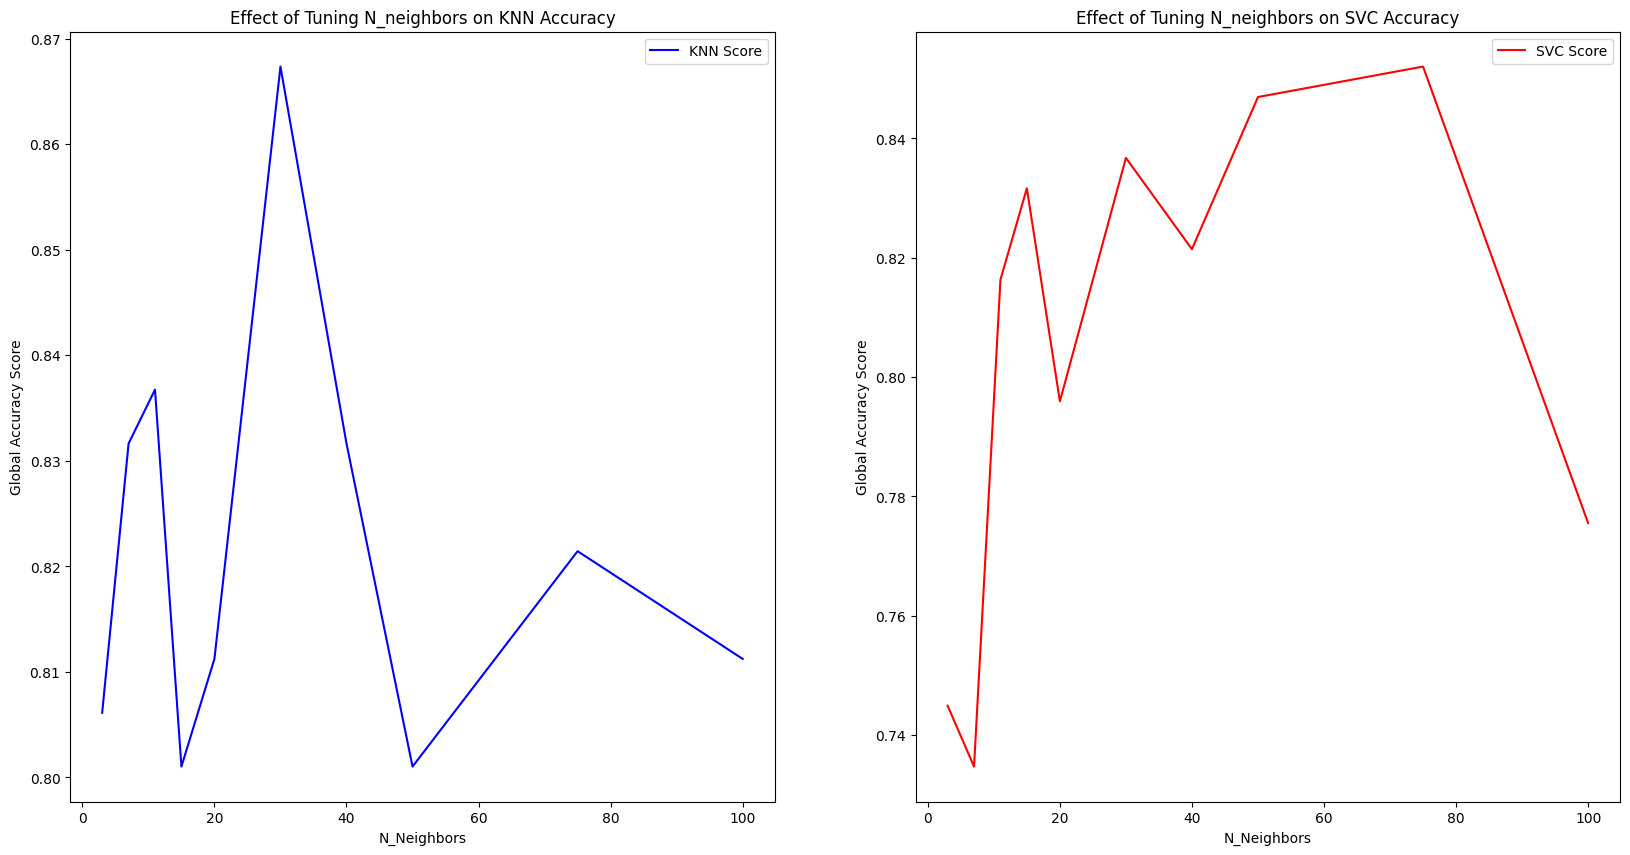

In [15]:
# compare results 

%matplotlib inline

plt.figure(figsize = [20,10])

plt.subplot(1,2,1)
plt.plot(radius, knntest_Scores, color='b', label='KNN Score')
plt.xlabel('N_Neighbors')
plt.ylabel('Global Accuracy Score')
plt.title('Effect of Tuning N_neighbors on KNN Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(radius, svctest_Scores, color='red',label='SVC Score')
plt.xlabel('N_Neighbors')
plt.ylabel('Global Accuracy Score')
plt.title('Effect of Tuning N_neighbors on SVC Accuracy')
plt.legend()
plt.show()

In [18]:
# svc grid search part 2
clfsvc = Pipeline([
 ("isomap", Isomap(n_jobs=-1, metric='euclidean', p=2)),
 ("svc", svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True))
 ])
param_grid2 = [{
 "isomap__n_neighbors": ([3, 7, 11, 15, 20, 30, 40, 50, 75, 100]),
 "isomap__n_components": [10, 30, 50, 100],
 }]
isogrid_searchsvc2 = GridSearchCV(clfsvc, param_grid2, cv=3)
isogrid_searchsvc2.fit(images, labels)

print(isogrid_searchsvc2.best_params_)
print(isogrid_searchsvc2.best_score_)

{'isomap__n_components': 100, 'isomap__n_neighbors': 75}
0.786206896551724


In [19]:
# create table 
isosvctable2 = pd.DataFrame(isogrid_searchsvc2.cv_results_)

isosvctable2.to_csv("isosvctable2.csv")

isosvctable2 = isosvctable2.sort_values(by=['rank_test_score']).head(5)
# to add to pdf
print(isosvctable2.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrlllrrrrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_isomap\_\_n\_components & param\_isomap\_\_n\_neighbors &                                             params &  split0\_test\_score &  split1\_test\_score &  split2\_test\_score &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       1.18619 &       0.00833 &          0.12314 &         0.00177 &                        100 &                        75 & \{'isomap\_\_n\_components': 100, 'isomap\_\_n\_neighb... &            0.81839 &            0.77701 &            0.76322 &          0.78621 &         0.02344 &                1 \\
       1.08267 &       0.00862 &          0.11788 &         0.00326 &                         50 &                        75 & \{'isomap\_\_n\_components': 50, 'isomap\_\_n\_neighbo... &            0.81149 &            0.77241 &            0.77011 &          0.78467 &         0.01899 &                2 \\
       0.

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_1160/2570818297.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(isosvctable2.to_latex(index=False,


In [20]:
# grid search part 2
clfknn = Pipeline([
 ("isomap", Isomap(n_jobs=-1, metric='euclidean', p=2)),
 ("knn", KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2))
 ])
param_grid2 = [{
 "isomap__n_neighbors": ([3, 7, 11, 15, 20, 30, 40, 50, 75, 100]),
 "isomap__n_components": [10, 30, 50, 100],
 }]
isogrid_searchknn = GridSearchCV(clfknn, param_grid2, cv=3)
isogrid_searchknn.fit(images, labels)

print(isogrid_searchknn.best_params_)
print(isogrid_searchknn.best_score_)

{'isomap__n_components': 100, 'isomap__n_neighbors': 3}
0.7938697318007663


In [21]:
# create table 
isoknntable2 = pd.DataFrame(isogrid_searchknn.cv_results_)

isoknntable2.to_csv("isoknntable2.csv")

isoknntable2 = isoknntable2.sort_values(by=['rank_test_score']).head(5)
# to add to pdf
print(isoknntable2.to_latex(index=False,
                  float_format="{:.5f}".format,))

\begin{tabular}{rrrrlllrrrrrr}
\toprule
 mean\_fit\_time &  std\_fit\_time &  mean\_score\_time &  std\_score\_time & param\_isomap\_\_n\_components & param\_isomap\_\_n\_neighbors &                                             params &  split0\_test\_score &  split1\_test\_score &  split2\_test\_score &  mean\_test\_score &  std\_test\_score &  rank\_test\_score \\
\midrule
       0.37033 &       0.00459 &          0.06997 &         0.00276 &                        100 &                         3 & \{'isomap\_\_n\_components': 100, 'isomap\_\_n\_neighb... &            0.80690 &            0.80230 &            0.77241 &          0.79387 &         0.01529 &                1 \\
       0.37098 &       0.02694 &          0.07059 &         0.00401 &                         50 &                         3 & \{'isomap\_\_n\_components': 50, 'isomap\_\_n\_neighbo... &            0.79770 &            0.79540 &            0.77011 &          0.78774 &         0.01250 &                2 \\
       0.

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_1160/3734134559.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(isoknntable2.to_latex(index=False,


In [25]:
# repeat optimal Isomap for KNN
isoknn = Isomap(n_components=100, n_neighbors=3, n_jobs=-1, metric='euclidean', p=2)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=2)

# recreate optimal split
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)

# transform into isomap embeddings
isoknn_xtrain = isoknn.fit_transform(xtrain)
isoknn_xtest = isoknn.transform(xtest)

# call predict() function 

predknniso, iso_knnscore, iso_knn_confusion, iso_knn_report = predict(knn, isoknn_xtrain, ytrain, isoknn_xtest, ytest)
iso_knn_confdf = create_confmat_df(iso_knn_confusion)
# save confusion matrix to avoid recomputing
iso_knn_confdf.to_csv("iso_knn_confdf.csv")

print("Overall Accuracy: {0:.2f}".format(iso_knnscore))

Overall Accuracy: 0.80


In [27]:
# repeat optimal Isomap for svc
isosvc = Isomap(n_components=100, n_neighbors=75, n_jobs=-1, metric='euclidean', p=2)
svc = svm.SVC(C=0.1, gamma=1, kernel='poly',probability=True)

# recreate optimal split
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.15, random_state=47, shuffle=True, stratify=labels)

# transform into isomap embeddings
isosvc_xtrain = isosvc.fit_transform(xtrain)
isosvc_xtest = isosvc.transform(xtest)

# call predict() function 

predsvciso, iso_svcscore, iso_svc_confusion, iso_svc_report = predict(svc, isosvc_xtrain, ytrain, isosvc_xtest, ytest)
iso_svc_confdf = create_confmat_df(iso_svc_confusion)
# save confusion matrix to avoid recomputing
iso_svc_confdf.to_csv("iso_svc_confdf.csv")

print("Overall Accuracy: {0:.2f}".format(iso_svcscore))

Overall Accuracy: 0.81
